In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [93]:
## Import data
data_read= pd.read_csv("../Mesures/data03.csv", index_col=0)


In [94]:
## Data verification
dd = data_read
matrix = pd.crosstab(dd['room'], dd['device_id'])

print(matrix)

device_id    C    G    R    V
room                         
LC410      442  498  500  467
LC412      456  491  500  469
LC413      500  500  500  500
LC414      451  481  500  474
LC415      452  493  500  480
LC416      455  497  500  477
LC417      500  100  500  500
LC424      500  500  500  500
LC426      500  500  500  500
LC437        0  500    0  500
LC442      540  500  500  500
LC443        0  500  500  500
LC448      500  500  500  500
LC455        0  500  500  500


In [95]:
## Positive representation
data = data_read.copy()
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [96]:
## Selection of APs
name_mac_relation = pd.read_csv("../Mesures/mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [97]:
AP_columns = list(data.columns[5:])
rooms = data['room'].unique()
not_mac_columns = list(data.columns[:5])

print("nb of rooms: ", len(rooms))
print("nb of APs: ", len(AP_columns))
print("not MAC columns: ", not_mac_columns)

nb of rooms:  14
nb of APs:  409
not MAC columns:  ['timestamp', 'room', 'device_id', 'door_status', 'room_part']


In [126]:
## Defining the classes to classify
# parts 1-4 in a room
# parts 5 in corridor groups
corridor_groups = [["LC410", "LC412", "LC413"], ["LC414", "LC415", "LC416"], ["LC424", "LC426"],["LC443", "LC448"]]

data["class"] = data["room"]
for i in range(len(corridor_groups)):
    samples_mask_of_corridor = data["room"].isin(corridor_groups[i]) & (data["room_part"] == 5)
    data["class"] = data["class"].mask(samples_mask_of_corridor, "C"+str(i))
    print("nb of samples in C"+str(i)+":", samples_mask_of_corridor.sum())
    
not_mac_columns = not_mac_columns + ["class"]

nb of samples in C0: 1155
nb of samples in C1: 1150
nb of samples in C2: 800
nb of samples in C3: 700


In [99]:
## Data partition
from sklearn.model_selection import train_test_split

# Random Split 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Device Split
#test_device = "V"
#test_data = data[data["device_id"] == test_device ]
#train_data = data[data["device_id"] != test_device]

# Verify the shapes of the training and testing sets
print("Training data size:", train_data.shape[0])
print("Testing data size:", test_data.shape[0])


Training data size: 20178
Testing data size: 5045


In [123]:
## Classification
import importlib
import rbf_classification as tt
importlib.reload(tt)

pred_class = "class"

tloc = tt.TLoc(train_data[[pred_class]+AP_columns], pred_class=pred_class)
tloc.train()


In [124]:
## Prediction
accuracy, prediction, ground_truth = tloc.pred(test_data)

Accuracy:  0.9609514370664024


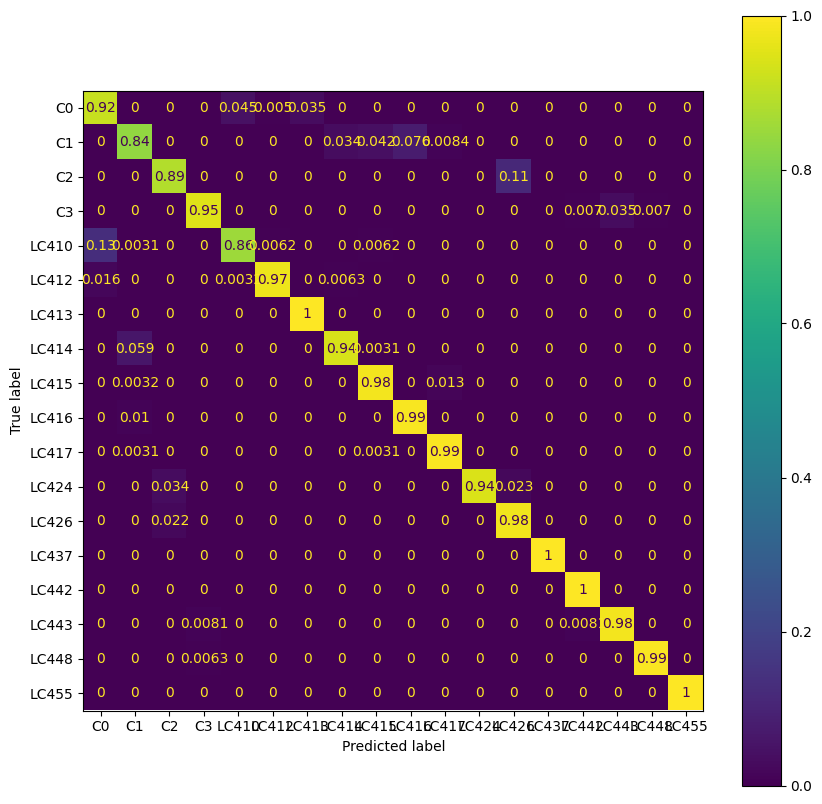

In [125]:
## Presentation of the results
print("Accuracy: ", accuracy)

fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(prediction, ground_truth, normalize='true'), display_labels=list(np.unique(ground_truth)))
cmd.plot(ax=ax)
plt.show()